In [37]:
import spacy
import pandas as pd
import numpy as np
from glob import glob
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from numpy.random import randint
from sklearn.mixture import BayesianGaussianMixture
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.manifold import TSNE
from math import floor
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14,8)

In [38]:
bib = pd.read_csv('bibliography/everyone.csv')

In [39]:
authorDfList = list(bib.groupby('author'))

In [40]:
authorDfDict = {author: df for author, df in authorDfList}

In [41]:
authorList = list(authorDfDict.keys())

In [42]:
len(authorList)

52

In [43]:
class textPieces(): 
    def __init__(self, author, df, sample=True, pieces=2): 
        self.author = author
        self.df = df
        self.labels = []
        for i, row in df.iterrows():
            try: 
                age = int(row.age)
            except: 
                age = str(row.age)
            try:
                ytd = int(row.yearsToDeath)
            except: 
                ytd = str(row.yearsToDeath)
            self.labels.append('%d-%s-%s-%s' % (row.date, age, ytd, row.title))
        self.texts = [self.getText(bookID) for bookID in df['id']]
        # Prune those where texts can't be found
        prunedTexts, prunedLabels = [], []
        for label, text in zip(self.labels, self.texts): 
            if text is not None: 
                prunedTexts.append(text)
                prunedLabels.append(label)
        self.texts = prunedTexts
        self.labels = prunedLabels
        self.lengths = [len(text) for text in self.texts]
        self.lowestLength = min(self.lengths)
#         print('Using texts: ', self.labels)
        if sample: 
            self.samples = [self.sample(text) for text in self.texts]
        else: 
            self.samples = self.texts
        if pieces > 1: 
            self.pieces = []
            self.makePieces(self.labels, self.samples, pieces)
        else: 
            self.pieces = self.texts
        
    def getText(self, bookID):
        database = 'sqlite:////home/jon/Code/gitenberg-scrape/pg-text-7.db'
        query = 'select text from text where id = ' + str(round(float(bookID)))
        df = pd.read_sql(query, database)
        if len(df) > 0: 
            return df.text[0]
        else:
            return None
        
    def sample(self, text): 
        """ Randomly samples from texts that are long, 
        so that we're comparing the same amount of text across documents."""
        chunkSize = self.lowestLength
        # We want a chunk of [a:b] where the max value of b is end-chunkSize
        textLength = len(text)
        maxEnd = textLength - chunkSize
        if maxEnd <= 0: 
            return text
        start = randint(0, maxEnd)
        return text[start:start+chunkSize]
    
    def makePieces(self, labels, samples, n): 
        pieceSize = self.lowestLength / n
        self.labels = []
        for label, sample in zip(labels, samples): 
            for i in range(n):
                pieceLabel = "%s-%s" % (label, i)
                start = int(i*pieceSize)
                end = int(start+pieceSize)
#                 print('Piece start: %s, piece end: %s' % (start, end))
                piece = sample[start:end]
                self.labels.append(pieceLabel)
                self.pieces.append(piece)

In [44]:
class authorAnalysis(): 
    def __init__(self, labels, docs): 
        self.labels = labels
        self.docs = docs
        self.features, self.matrix = self.vectorize()
        # Assume the date is the first four characters of the label. 
        self.pieceDates = [int(label[:4]) for label in self.labels]
        self.pieceTdds = []
        for label in self.labels:
            try:
                tdd = int(label.split('-')[2])
            except: 
                tdd = 0
            self.pieceTdds.append(tdd)
        # Try to assign "early," "middle," and "late" categories (0, 1, 2) based on years. 
        self.categories = [round(cat) for cat in self.rescale(self.pieceDates, 0, 2)]
        self.tddCats = [self.getTddCat(tdd) for tdd in self.pieceTdds]
    
    def getTddCat(self, tdd):
        """ Map time to death to three categories: 
        very late (5 years to death), late (ten years to death), other."""
        vLate = {tdd: 2 for tdd in range(5)}
        late = {tdd: 1 for tdd in range(5, 10)}
        other = {tdd: 0 for tdd in range(10, 120)}
        tddDict = {**vLate, **late, **other}
        return tddDict[tdd]
        
    def vectorize(self): 
        tfidf = TfidfVectorizer(use_idf=False, max_features=400)
        matrix = tfidf.fit_transform(self.docs).todense()
        features = tfidf.get_feature_names()
        return features, matrix
    
    def vectorDF(self):
        """ Just a helper to visualize the TFIDF table."""
        return pd.DataFrame(self.matrix, columns=self.features, index=self.labels)
    
    def doPCA(self): 
        pca = PCA(n_components=5)
        return pca.fit_transform(self.matrix)
        
    def doLSA(self):
        lsa = TruncatedSVD(n_components=5)
        return lsa.fit_transform(self.matrix)
        
    def plotPCA(self, tSNE=False, labels=True, saveTo=False, clustering='bgm'): 
        if tSNE: 
            pcaTable = self.doTSNE()
        else: 
            pcaTable = self.doPCA()
        Xs = [thing[0] for thing in pcaTable]
        Ys = [thing[1] for thing in pcaTable]
        df = pd.DataFrame(pcaTable, index=self.labels)
        #df['distance'] = np.sqrt(df[0]**2 + df[1]**2)     # Pythagorean theorem   
        df['distance'] = linalg.norm(df)
        if clustering == 'kmeans': 
            colors = self.kmeans()
        if clustering == 'bgm': 
            colors = self.bgm()
        ax = plt.scatter(df[0], df[1], s=self.size, c=colors)
        if labels: 
            for i, label in enumerate(self.labels):
                plt.annotate(label, (Xs[i], Ys[i]))
        if saveTo: 
            fig = ax.get_figure()
            fig.tight_layout()
            fig.savefig('pca-' + saveTo + '.png') # save it to a file
        return df.sort_values('distance', ascending=False)
    
    def rescale(self, array, low, high):
        minimum = min(array)
        maximum = max(array)
        diff = maximum - minimum
        diffScale = high - low
        return list(map( lambda x: (int(x)-minimum)*(diffScale/diff)+low, array))
    
    @property
    def size(self, by='date'): 
        if by == 'date': 
            return self.rescale(self.pieceDates, 20, 500)

    def kmeans(self): 
        pcaOut = self.doPCA()
        kmeans = KMeans(n_clusters=3)
        return kmeans.fit_predict(pcaOut)
    
    def bgm(self): 
        pcaOut = self.doPCA()
        bgm = BayesianGaussianMixture(n_components=3).fit(pcaOut)
        return bgm.predict(pcaOut)
        
    def metrics(self): 
        randK = adjusted_rand_score(self.categories, self.kmeans())
        randB = adjusted_rand_score(self.categories, self.bgm())
#         print('Adjusted rand score, Kmeans: ', randK)
#         print('Adjusted rand score, BGM: ', randB)
        randK = adjusted_mutual_info_score(self.categories, self.kmeans())
        randB = adjusted_mutual_info_score(self.categories, self.bgm())
#         print('Adjusted mutual info score, Kmeans: ', randK)
#         print('Adjusted mutual info score, BGM: ', randB)
        
    def periodicity(self): 
        return adjusted_rand_score(self.categories, self.bgm())
    
    def categorize(self, cats):
        pointsDict = {cat: [] for cat in set(cats)}
        for point, cat in zip(self.doPCA(), cats):
            pointsDict[cat].append(point)
        return pointsDict
                              
    def categorizeBGM(self):
        return self.categorize(self.bgm())
    
    def categorizePoints(self):
        return self.categorize(self.categories)
    
    def categorizeTdd(self):
        return self.categorize(self.tddCats)
    
    def centroids(self, cats): 
        centroidsDict = {}
        for key, val in cats.items():
            centroid = np.mean(val, axis=0)
            centroidsDict[key] = centroid
        return centroidsDict
    
    def centroidsBGM(self): 
        return self.centroids(self.categorizeBGM())
    
    def centroidsCats(self): 
        return self.centroids(self.categorizePoints())
        
    def centroidsTddCats(self):
        return self.centroids(self.categorizeTdd())
    
    def lateDistinctiveness(self): 
        return np.linalg.norm(self.centroidsCats()[2])
    
    def earlyDistinctiveness(self):
        return np.linalg.norm(self.centroidsCats()[0])
    
    def lateness(self):
        return self.lateDistinctiveness() - self.earlyDistinctiveness()
    
    def lateDistinctivenessTdd(self):
        if 2 in self.centroidsTddCats(): 
            return np.linalg.norm(self.centroidsTddCats()[2])
        #elif 1 in self.centroidsTddCats():
        #    return np.linalg.norm(self.centroidsTddCats()[1])
        else:
            return 0
    
    def earlyDistinctivenessTdd(self):
        if 0 in self.centroidsTddCats():
            return np.linalg.norm(self.centroidsTddCats()[0])
        else:
            return 0
    
    def tddLateness(self):
        return self.lateDistinctivenessTdd() - self.earlyDistinctivenessTdd()

In [45]:
def doAnalysis(author):
    df = authorDfDict[author]
    pieces = textPieces(author, df)
    analysis = authorAnalysis(pieces.labels, pieces.pieces)
    #print(analysis.plotPCA())
    print(analysis.metrics())
    print(analysis.periodicity())
    return analysis

In [46]:
latenesses = {author: [] for author in authorList}
periodicities = {author: [] for author in authorList}
tddLatenesses = {author: [] for author in authorList}

In [47]:
nTrials = 10
for i in range(nTrials):
    for author in authorList:
        print("Analyzing: ", author)
        analysis = doAnalysis(author)
        latenesses[author].append(analysis.lateness())
        tddLatenesses[author].append(analysis.tddLateness())
        periodicities[author].append(analysis.periodicity())

Analyzing:  Allen, Grant
None
-0.08822824262766726
Analyzing:  Anonymous
None
-0.15176151761517606
Analyzing:  Anstey, F.
None
0.003887269193391646
Analyzing:  Barr, Robert
None
0.16076593198364417
Analyzing:  Bennett, Arnold
None
0.05689031983719585
Analyzing:  Bindloss, Harold
None
0.44852914958103046
Analyzing:  Blackwood, Algernon
None
0.19947077847832478
Analyzing:  Buchan, John
None
0.28324324324324324
Analyzing:  Carroll, Lewis
None
1.0
Analyzing:  Collins, Wilkie
None
0.0635802243578032
Analyzing:  Conrad, Joseph
None
0.004476573606363977
Analyzing:  Corelli, Marie
None
0.041282712863988165
Analyzing:  Defoe, Daniel
None
0.01984628854946981
Analyzing:  Dell, Ethel M. (Ethel May)
None
0.31434628975265017
Analyzing:  Dickens, Charles
None
-0.015665567328608538
Analyzing:  Doyle, Arthur Conan
None
0.024112954983038434
Analyzing:  Dunsany, Lord
None
0.2987328120787275
Analyzing:  Eliot, George
None
0.031007751937984496
Analyzing:  Farnol, Jeffery
None
0.2305129913391073
Analyzing: 

/home/jon/Code/late-style-PCA/venv/lib/python3.6/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


None
0.03483148596056455
Analyzing:  Sinclair, May
None
0.1599210266535045
Analyzing:  Stevenson, Robert Louis
None
-0.019337342294540698
Analyzing:  Thackeray, William Makepeace
None
0.11210551106924162
Analyzing:  Tracy, Louis
None
0.1129992737835875
Analyzing:  Trollope, Anthony
None
0.0031446017017497606
Analyzing:  Various
None
-0.020245842371655748
Analyzing:  Von Arnim, Elizabeth
None
0.1951219512195122
Analyzing:  Wallace, Edgar
None
0.13162705667276053
Analyzing:  Wilde, Oscar
None
0.035075593952483775
Analyzing:  Zangwill, Israel
None
0.31102362204724415
Analyzing:  Allen, Grant
None
-0.040816326530612276
Analyzing:  Anonymous
None
-0.11717974180734853
Analyzing:  Anstey, F.
None
0.03402187120291613
Analyzing:  Barr, Robert
None
0.04430748729907556
Analyzing:  Bennett, Arnold
None
0.02666661474568785
Analyzing:  Bindloss, Harold
None
0.22712749510427044
Analyzing:  Blackwood, Algernon
None
0.15442870144608367
Analyzing:  Buchan, John
None
0.23663578047042058
Analyzing:  Carro

None
-0.09710583153347735
Analyzing:  Oppenheim, E. Phillips (Edward Phillips)
None
0.07400586122475399
Analyzing:  Quiller-Couch, Arthur
None
-0.008040822638008335
Analyzing:  Rohmer, Sax
None
0.20689655172413793
Analyzing:  Scott, Walter
None
0.165255672197765
Analyzing:  Shakespeare, William
None
-0.01138667085715453
Analyzing:  Sinclair, May
None
0.13983739837398373
Analyzing:  Stevenson, Robert Louis
None
-0.032724420038103705
Analyzing:  Thackeray, William Makepeace
None
-0.01036269430051814
Analyzing:  Tracy, Louis
None
0.1641701617735171
Analyzing:  Trollope, Anthony
None
0.010454718749382922
Analyzing:  Various
None
-0.11678832116788315
Analyzing:  Von Arnim, Elizabeth
None
0.09302325581395353
Analyzing:  Wallace, Edgar
None
0.026095060577819202
Analyzing:  Wilde, Oscar
None
-0.15273972602739727
Analyzing:  Zangwill, Israel
None
0.09259259259259259
Analyzing:  Allen, Grant
None
-0.19086294416243663
Analyzing:  Anonymous
None
0.010682204418548223
Analyzing:  Anstey, F.
None
0.0

None
0.0630719155588182
Analyzing:  MacDonald, George
None
-0.020785219399538105
Analyzing:  Meredith, George
None
0.11073825503355707
Analyzing:  Mitford, Bertram
None
0.1494093120222377
Analyzing:  Nesbit, E. (Edith)
None
0.058309037900874605
Analyzing:  Oliphant, Mrs. (Margaret)
None
-0.09710583153347735
Analyzing:  Oppenheim, E. Phillips (Edward Phillips)
None
0.13303955254926733
Analyzing:  Quiller-Couch, Arthur
None
-0.007235805566901971
Analyzing:  Rohmer, Sax
None
-0.032653061224489834
Analyzing:  Scott, Walter
None
0.0672392147277434
Analyzing:  Shakespeare, William
None
0.10282659775195958
Analyzing:  Sinclair, May
None
-0.05407187603033305
Analyzing:  Stevenson, Robert Louis
None
0.02265634030747888
Analyzing:  Thackeray, William Makepeace
None
0.06364749082007347
Analyzing:  Tracy, Louis
None
0.13837965700768773
Analyzing:  Trollope, Anthony
None
0.04121501019197529
Analyzing:  Various
None
-0.040816326530612276
Analyzing:  Von Arnim, Elizabeth
None
0.1951219512195122
Analy

None
0.03007518796992479
Analyzing:  Jerome, Jerome K. (Jerome Klapka)
None
0.14456858258177416
Analyzing:  Kipling, Rudyard
None
-0.052987844821311435
Analyzing:  Lang, Andrew
None
0.24096385542168672
Analyzing:  Le Gallienne, Richard
None
0.1548831635710006
Analyzing:  Le Queux, William
None
0.07735792547482967
Analyzing:  MacDonald, George
None
-0.004681310767014758
Analyzing:  Meredith, George
None
0.45488721804511273
Analyzing:  Mitford, Bertram
None
0.2604320804971885
Analyzing:  Nesbit, E. (Edith)
None
0.11979695431472076
Analyzing:  Oliphant, Mrs. (Margaret)
None
-0.048036070406659165
Analyzing:  Oppenheim, E. Phillips (Edward Phillips)
None
0.1636144665578164
Analyzing:  Quiller-Couch, Arthur
None
-0.04073058294917425
Analyzing:  Rohmer, Sax
None
0.07485134662469392
Analyzing:  Scott, Walter
None
0.24082103067888702
Analyzing:  Shakespeare, William
None
0.017262232863170256
Analyzing:  Sinclair, May
None
0.04909560723514207
Analyzing:  Stevenson, Robert Louis
None
0.0254686947

In [48]:
meanLatenesses = {author: np.mean(lateList) for author, lateList in latenesses.items()}

In [49]:
meanLatenessesSeries = pd.Series(meanLatenesses)
#meanLatenessesSeries.plot(kind='bar')

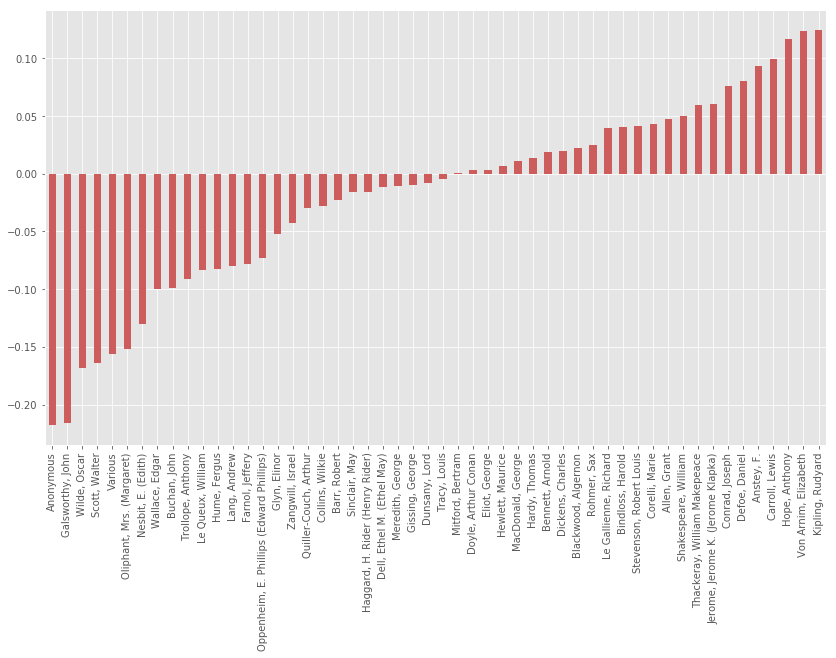

In [50]:
meanLatenessesSeries.sort_values().plot(kind='bar', color='indianred')

In [51]:
meanLatenessesSeries.mean()

-0.0178095547021789

In [52]:
latenesses

{'Allen, Grant': [-0.039499032920843655,
  0.14197377871391043,
  0.1307354938995703,
  -0.01949765377415011,
  0.09987035324414628,
  -0.027253906799980132,
  0.020746639476137113,
  0.06993765272211042,
  0.057643298911516705,
  0.035427667929313206],
 'Anonymous': [-0.19995993510963378,
  -0.21137869903850176,
  -0.2565481106278482,
  -0.20917390698420052,
  -0.25938012119621523,
  -0.217220072204894,
  -0.20977306471967164,
  -0.17923694093993678,
  -0.20716169086010738,
  -0.2290706338179851],
 'Anstey, F.': [0.08302628772262499,
  0.15587964425671874,
  0.10489561460656764,
  0.09100269021018134,
  0.07427095238438777,
  0.07657613219173828,
  0.0955535754285375,
  0.0721554000270832,
  0.08318161003725025,
  0.09971792590441683],
 'Barr, Robert': [-0.01808268005231191,
  -0.03661822344219662,
  -0.029664265203620102,
  -0.014194611398162582,
  -0.02422045057172227,
  -0.028084089762183045,
  -0.0027462253801232017,
  -0.023834966389551224,
  -0.023093718297574173,
  -0.027776225

In [53]:
meanPeriodicities = {author: np.mean(pList) for author, pList in periodicities.items()}

In [54]:
meanPeriodicitiesSeries = pd.Series(meanPeriodicities)
#meanPeriodicitiesSeries.plot(kind='bar', color='indianred')

In [55]:
meanLatenesses

{'Allen, Grant': 0.04700842914017306,
 'Anonymous': -0.2178903175498994,
 'Anstey, F.': 0.09362598327695065,
 'Barr, Robert': -0.02283154563394974,
 'Bennett, Arnold': 0.019146227994568,
 'Bindloss, Harold': 0.04023651869342495,
 'Blackwood, Algernon': 0.022573389623337648,
 'Buchan, John': -0.09887409168129212,
 'Carroll, Lewis': 0.09913768335564596,
 'Collins, Wilkie': -0.028004720511750358,
 'Conrad, Joseph': 0.0757978701265468,
 'Corelli, Marie': 0.04271938939338142,
 'Defoe, Daniel': 0.08058557503656985,
 'Dell, Ethel M. (Ethel May)': -0.01180443105828492,
 'Dickens, Charles': 0.01939090462933784,
 'Doyle, Arthur Conan': 0.0029631054713646415,
 'Dunsany, Lord': -0.008203890444498287,
 'Eliot, George': 0.0035737100343880153,
 'Farnol, Jeffery': -0.07828177111356208,
 'Galsworthy, John': -0.21592793404546068,
 'Gissing, George': -0.010038017482655776,
 'Glyn, Elinor': -0.05263945716493688,
 'Haggard, H. Rider (Henry Rider)': -0.015540880798583701,
 'Hardy, Thomas': 0.013936377524875

In [56]:
meanPeriodicities

{'Allen, Grant': -0.03983029796842062,
 'Anonymous': -0.013939150541249506,
 'Anstey, F.': -0.03303685798115738,
 'Barr, Robert': 0.18126328956869134,
 'Bennett, Arnold': 0.07562538652170775,
 'Bindloss, Harold': 0.2965210133358304,
 'Blackwood, Algernon': 0.12169134290623489,
 'Buchan, John': 0.14633941222494434,
 'Carroll, Lewis': 0.5227449021566668,
 'Collins, Wilkie': 0.03678874837499503,
 'Conrad, Joseph': 0.07542402254209592,
 'Corelli, Marie': 0.14904418011542842,
 'Defoe, Daniel': 0.026527274262111433,
 'Dell, Ethel M. (Ethel May)': 0.3378927493316629,
 'Dickens, Charles': 0.014055695577363289,
 'Doyle, Arthur Conan': 0.030290627375433133,
 'Dunsany, Lord': 0.19476865056830567,
 'Eliot, George': 0.01646005176003475,
 'Farnol, Jeffery': 0.16634967613821677,
 'Galsworthy, John': 0.0070177637073264385,
 'Gissing, George': 0.07783863247897312,
 'Glyn, Elinor': 0.2080050653679349,
 'Haggard, H. Rider (Henry Rider)': 0.06700460311491199,
 'Hardy, Thomas': 0.07711447172147598,
 'Hewle

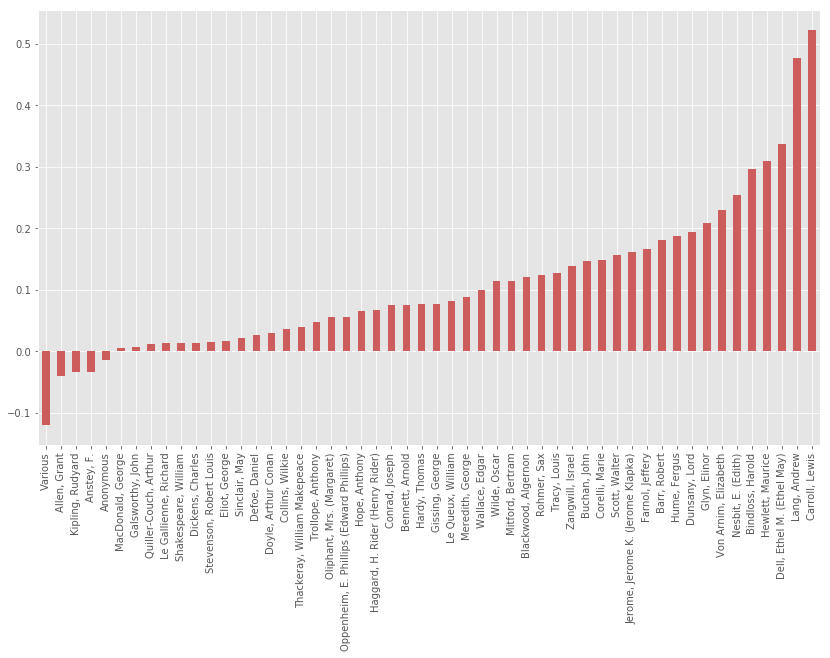

In [57]:
meanPeriodicitiesSeries.sort_values().plot(kind='bar', color='indianred')

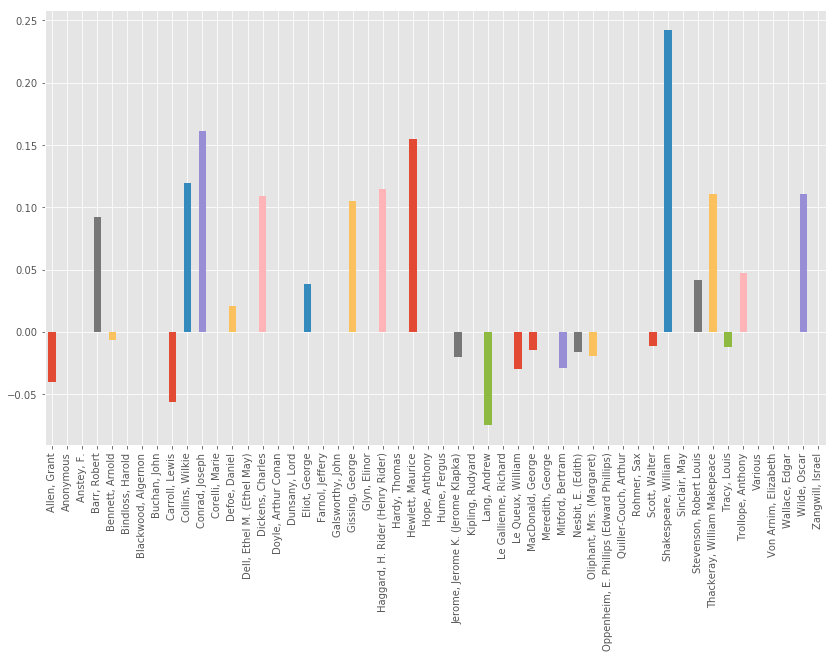

In [74]:
meanTddLatenesses = {author: np.mean(lateList) for author, lateList in tddLatenesses.items()}
meanTddLatenessesSeries = pd.Series(meanTddLatenesses)
meanTddLatenessesSeries.plot(kind='bar')

In [75]:
meanTddLatenessesSeries.mean()

0.02190520213530652

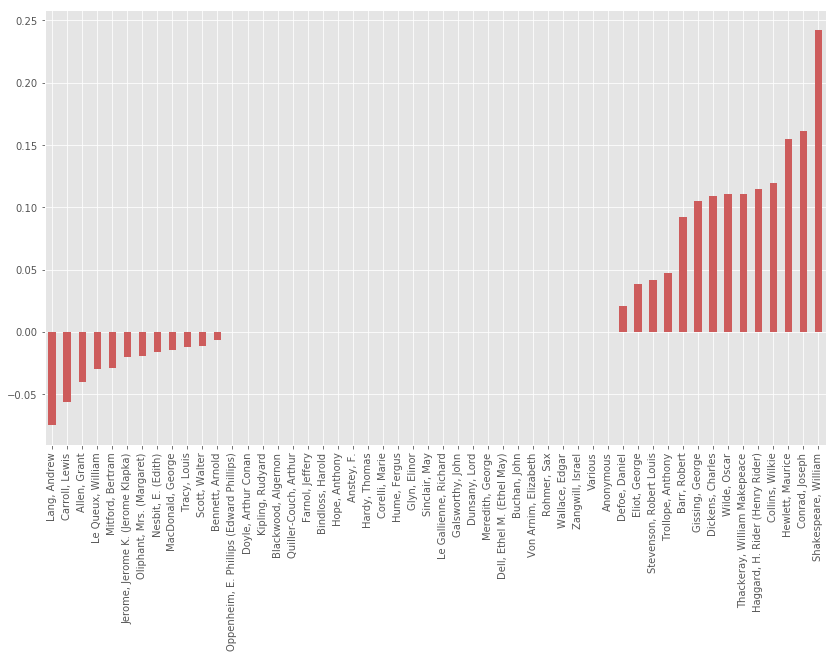

In [76]:
meanTddLatenessesSeries.sort_values().plot(kind='bar', color='indianred')

In [77]:
meanTddLatenessesSeries.mean()

0.02190520213530652

In [67]:
del meanTddLatenessesSeries['Shakespeare, William']

In [69]:
meanTddLatenessesSeries.mean()

0.017583720209326793

In [78]:
meanTddLatenessesSeries[meanTddLatenessesSeries != 0].mean()

0.02190520213530652